In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [3]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [4]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,ot.ProvinceUID,pr.Description AS province ,ot.DistrictUID ,  di.Description AS district 
, ot.AreaUID , ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [5]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [6]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO008001532,56,2018-11-07 08:04:43.603,386,ROYAL PHARMACY 2,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,80,Niralini Waruna,2,The West Central Pharma (Pvt) Ltd.,243,Myotan 50mg 100's,1.0,948.7,1081.5,0.0,0.0,948.7,2018,November,11,7,4,Wednesday,8
1,IN0066000118,0,2018-11-02 16:25:16.267,2608,Western Medicare,16.0,Southern Province,18.0,Matara,396.0,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,219,Diclofenac Sodium Gel 20gm,10.0,53.6,61.0,0.0,0.0,536.0,2018,November,11,2,6,Friday,16
2,IN0066000118,0,2018-11-02 16:25:16.267,2608,Western Medicare,16.0,Southern Province,18.0,Matara,396.0,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,219,Diclofenac Sodium Gel 20gm,0.0,53.6,61.0,1.0,1.0,0.0,2018,November,11,2,6,Friday,16
3,IN0066000130,0,2018-11-03 12:22:27.260,2741,Kataragama Pharmacy,30.0,Uva Province,32.0,Monaragala,394.0,Kataragama,155,Desun Chamara,14,Unichemist Distributor,51,TRANSLIPO - CB CREAM 15G,10.0,81.2,92.5,0.0,0.0,812.0,2018,November,11,3,7,Saturday,12
4,IN0066000130,0,2018-11-03 12:22:27.260,2741,Kataragama Pharmacy,30.0,Uva Province,32.0,Monaragala,394.0,Kataragama,155,Desun Chamara,14,Unichemist Distributor,51,TRANSLIPO - CB CREAM 15G,0.0,81.2,92.5,1.0,1.0,0.0,2018,November,11,3,7,Saturday,12


### What is the best date of week for sales?

In [7]:
#group data
Week_Sales = invoice_All.groupby("DateName").agg({'GrossValue':'sum' , 'WeekDay':'max' }).reset_index()
# setting WeekDay as index column
Week_Sales = Week_Sales.set_index("WeekDay")
Week_Sales.sort_index(inplace=True)
Week_Sales.reset_index()

,WeekDay,DateName,GrossValue
0,1,Sunday,4.351611e+07
1,2,Monday,5.356381e+08
2,3,Tuesday,5.522812e+08
3,4,Wednesday,5.036746e+08
4,5,Thursday,6.061361e+08
5,6,Friday,5.941643e+08
6,7,Saturday,3.611790e+08


### What is the best week day for sales?

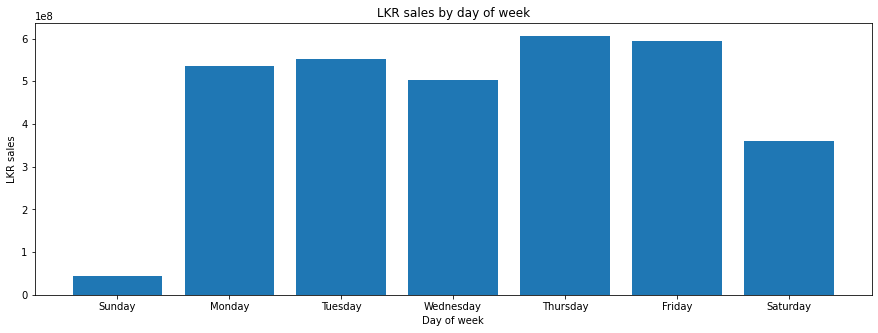

In [9]:
plt.bar(Week_Sales.DateName , Week_Sales.GrossValue)
plt.xlabel("Day of week")
plt.ylabel("LKR sales")
plt.title("LKR sales by day of week")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()